# IS319 - Deep Learning

## TP2 - Dogs vs. cats (TensorFlow/Keras)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the TensorFlow/Keras library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [14]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow[and-cuda]
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [15]:
# Import TensorFlow modules (edit this list if needed)
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.random.set_seed(123)

print(tf.reduce_sum(tf.random.normal([10000, 10000])))
print(f'TensorFlow version: {tf.__version__}')

tf.Tensor(-19989.361, shape=(), dtype=float32)
TensorFlow version: 2.14.0


## Utility function

In [16]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

## 1. Load and explore the dataset

In [17]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
valid_cat_fnames = os.listdir(valid_cats_dir)
valid_dog_fnames = os.listdir(valid_dogs_dir)
print(train_dog_fnames[:10])
print(train_cat_fnames[:10])
print(valid_dog_fnames[:10])
print(valid_cat_fnames[:10])

File ‘/tmp/cats_and_dogs_filtered.zip’ already there; not retrieving.


Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['dog.173.jpg', 'dog.315.jpg', 'dog.132.jpg', 'dog.329.jpg', 'dog.30.jpg', 'dog.214.jpg', 'dog.31.jpg', 'dog.456.jpg', 'dog.785.jpg', 'dog.765.jpg']
['cat.275.jpg', 'cat.431.jpg', 'cat.261.jpg', 'cat.998.jpg', 'cat.920.jpg', 'cat.778.jpg', 'cat.55.jpg', 'cat.256.jpg', 'cat.999.jpg', 'cat.803.jpg']
['dog.2482.jpg', 'dog.2012.jpg', 'dog.2352.jpg', 'dog.2014.jpg', 'dog.2094.jpg', 'dog.2311.jpg', 'dog.2440.jpg', 'dog.2067.jpg', 'dog.2152.jpg', 'dog.2460.jpg']
['cat.2367.jpg', 'cat.2359.jpg', 'cat.2112.jpg', 'cat.2295.jpg', 'cat.2464.jpg', 'cat.2269.jpg', 'cat.2028.jpg', 'cat.2145.jpg', 'cat.2213.jpg', 'cat.2286.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

train sets 2 first rows | valid sets 2 last rows: 


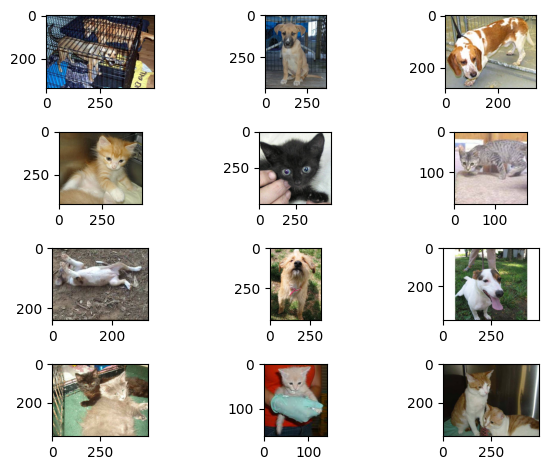

In [18]:
# YOUR CODE HERE
import matplotlib.image as mpimg
n = 3
train_dog_imgs = [mpimg.imread(os.path.join(train_dogs_dir, fname)) for fname in train_dog_fnames[:n]]
train_cat_imgs = [mpimg.imread(os.path.join(train_cats_dir, fname)) for fname in train_cat_fnames[:n]]
valid_dog_imgs = [mpimg.imread(os.path.join(valid_dogs_dir, fname)) for fname in valid_dog_fnames[:n]]
valid_cat_imgs = [mpimg.imread(os.path.join(valid_cats_dir, fname)) for fname in valid_cat_fnames[:n]]
imgs = [train_dog_imgs, train_cat_imgs, valid_dog_imgs, valid_cat_imgs]

f, axarr = plt.subplots(4,n)
print("train sets 2 first rows | valid sets 2 last rows: ")
for i in range(4) :
    for j in range(n) :
        axarr[i,j].imshow(imgs[i][j])

plt.tight_layout()
plt.show()

## 2. Prepare the dataset

**(Question)** Following the documentation, use the `tf.keras.utils.image_dataset_from_directory` function to create `train_dataset` and `valid_dataset` objects from the directory paths defined above. Make sure to have binary labels as we are doing binary classification. To start, you can use a lower image size (for example 128x128).

In [19]:
# YOUR CODE HERE
def clean_df(x, y) :
    # normalize and one hot encode y
    return x / 255. , tf.one_hot(y, 2)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred', image_size=(128, 128), shuffle=True, seed=42).map(lambda x, y : clean_df(x, y))
valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir, labels='inferred', image_size=(128, 128), shuffle=True, seed=42).map(lambda x, y : clean_df(x, y))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show its summary with the `model.summary()`method.
Make sure to include a layer to normalize input data (or to normalize your dataset object beforehand).

In [56]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy

is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')

with tf.device(gpus[0].name):
    CNN = Sequential()
    CNN.add(Input(shape=(128, 128, 3)))
    CNN.add(Conv2D(32, (3, 3), activation='relu'))
    CNN.add(Conv2D(64, (3, 3), activation='relu'))
    CNN.add(Conv2D(64, (3, 3), activation='relu'))
    CNN.add(MaxPooling2D((2, 2)))
    
    CNN.add(Flatten())
    
    CNN.add(Dense(32, activation="relu"))
    CNN.add(Dense(16, activation="relu"))
    CNN.add(Dense(2, activation="softmax"))

    CNN.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_72 (Conv2D)          (None, 124, 124, 64)      18496     
                                                                 
 conv2d_73 (Conv2D)          (None, 122, 122, 64)      36928     
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 238144)            0         
                                                                 
 dense_28 (Dense)            (None, 32)                7620640   
                                                     

2023-11-07 15:57:20.132890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 15:57:20.133091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 15:57:20.133170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

**(Question)** "Compile" and train your model with an appropriate loss function. Monitor train and validation accuracy (you can use the `plot_loss_acc` function defined above). You should be able to reach a validation accuracy >70%. Analyze your results.

In [57]:
# YOUR CODE HERE
with tf.device(gpus[0].name):
    CNN.compile(optimizer='SGD', loss="BinaryCrossentropy", metrics=["accuracy"])
    history = CNN.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/20


63/63 [==============================] - 6s 56ms/step - loss: 0.6940 - accuracy: 0.4945 - val_loss: 0.6920 - val_accuracy: 0.5110
Epoch 2/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6909 - accuracy: 0.5295 - val_loss: 0.6892 - val_accuracy: 0.5770
Epoch 3/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6870 - accuracy: 0.5540 - val_loss: 0.6845 - val_accuracy: 0.5560
Epoch 4/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6813 - accuracy: 0.5805 - val_loss: 0.6810 - val_accuracy: 0.5670
Epoch 5/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6751 - accuracy: 0.5785 - val_loss: 0.6780 - val_accuracy: 0.5600
Epoch 6/20
63/63 [==============================] - 3s 41ms/step - loss: 0.6714 - accuracy: 0.5935 - val_loss: 0.6708 - val_accuracy: 0.5920
Epoch 7/20
63/63 [==============================] - 3s 42ms/step - loss: 0.6638 - accuracy: 0.5995 - val_loss: 0.6646 - val_accuracy: 0.5970
Epoch 8/20
63/63 [======

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe? 

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [ ]:
import cv2
import numpy as np
from skimage.transform import AffineTransform, warp
from skimage.exposure import rescale_intensity

def rotate_image(image, angle):
    rotated_image = np.array(Image.fromarray(image).rotate(angle))
    return rotated_image

def translate_image(image, tx, ty):
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

def flip_image(image, horizontal=True):
    if horizontal:
        flipped_image = np.fliplr(image)
    else:
        flipped_image = np.flipud(image)
    return flipped_image

def zoom_image(image, scale_factor):
    zoomed_image = warp(image, AffineTransform(scale=(scale_factor, scale_factor)))
    return zoomed_image


def augment_dataset(X, y):
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        original_image = X[i]
        label = y[i]

        X_aug.append(original_image)
        y_aug.append(label)

        for _ in range(num_augmentations):
            augmented_image = augment_image(original_image, 
                                            rotation_angle=np.random.uniform(-15, 15),
                                            tx=np.random.randint(-10, 10),
                                            ty=np.random.randint(-10, 10),
                                            flip_horizontal=np.random.choice([True, False]),
                                            zoom_factor=np.random.uniform(0.9, 1.1))
            X_aug.append(augmented_image)
            y_aug.append(label)

    return np.array(X_aug), np.array(y_aug)


NotImplementedError: 

**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [ ]:
# YOUR CODE HERE
from tensorflow.keras.applications import VGG16

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Compile and train your model. You should be able to reach a validation accuracy >87%. Analyze your results and compare with your initial model trained from scratch.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()